In [1]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [ ]:
import os
import torch
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import soundfile as sf
from tqdm import tqdm
# from pydub import AudioSegment
from scipy.ndimage import label
from torchvision import models
from torchvision import transforms
from PIL import Image
from google.colab import files
from google.cloud import storage

### Import Colab

In [ ]:
# firts_time = False

In [ ]:
if firts_time:
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))


Saving projetos-aleatorios-379913-61df4a1c249e.json to projetos-aleatorios-379913-61df4a1c249e.json
User uploaded file "projetos-aleatorios-379913-61df4a1c249e.json" with length 2372 bytes


In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/projetos-aleatorios-379913-61df4a1c249e.json'

In [ ]:
storage_client = storage.Client()

In [ ]:
bucket_name = 'projeto_musical'
csv_file_name = 'labels.csv'
local_file_path = '/content/' + csv_file_name

# Cria um objeto bucket
bucket = storage_client.get_bucket(bucket_name)

# Cria um objeto blob
blob = bucket.blob(csv_file_name)

# Baixa o arquivo para o ambiente local
blob.download_to_filename(local_file_path)

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'variation_chord_audio.rar'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
# Descompacta o arquivo RAR
# !mkdir /content/
!unrar x {local_rar_path} chords

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'noise_audios.rar'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
# Descompacta o arquivo RAR
# !mkdir /content/
!unrar x {local_rar_path} /content/chords


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/noise_audios.rar


Would you like to replace the existing file /content/chords/noise_audios/short_sounds/garage_foley/Garage Foley - 1.wav
585672 bytes, modified on 2017-06-23 02:38
with a new one
585672 bytes, modified on 2017-06-23 02:38

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


### Import de Dados e Tratamentos Básicos

In [ ]:
audio_folder = 'chords/variation_chord_audio/'

In [ ]:
labels = pd.read_csv('labels.csv')
labels['file_path'] = labels['file_name'].apply(lambda x: os.path.join(audio_folder, x))
labels['chord_idx'] = pd.Categorical(labels['chord']).codes

In [ ]:
def filter_rows(row):
    chord_ajusted = row['chord'].replace('7#5','aug7') if '7#5' in row['chord'] else row['chord']
    chord_ajusted = chord_ajusted.replace('9#5','aug9') if '9#5' in row['chord'] else row['chord']
    chord_ajusted = chord_ajusted.replace('#','s').replace('\\','_')
    clean_prefix = row['clean'].split('_')[0] if '_' in row['clean'] else row['clean']
    chord_prefix = chord_ajusted.split('\\')[0]
    return clean_prefix == chord_prefix or chord_ajusted in row['clean']

# Aplicar o filtro
filtered_rows = labels[labels.apply(filter_rows, axis=1)]

### Equilíbrio de Classes

In [ ]:
analise = filtered_rows['chord'].value_counts()
analise

E7sus4     141
F#7sus4    138
Bm11       137
Cm11       134
Cmaj13     133
          ... 
D#aug       31
C5          31
D#5         28
D5          28
C#5         28
Name: chord, Length: 346, dtype: int64

In [ ]:
print(
    f'Media: {round(analise.mean(),2)}',
    f'Percentil 25: {round(analise.quantile(0.25),2)}',
    f'Mediana: {round(analise.median(),2)}',
    f'Percentil 75: {round(analise.quantile(0.75),2)}',
    f'Desvio Padrão: {round(analise.std(),2)}',
    f'Moda: {analise.mode()}',
    f'Max: {analise.max()}',
    f'Min: {analise.min()}',
    sep='\n'
)

Media: 84.15
Percentil 25: 69.0
Mediana: 82.0
Percentil 75: 99.0
Desvio Padrão: 24.27
Moda: 0    87
Name: chord, dtype: int64
Max: 141
Min: 28


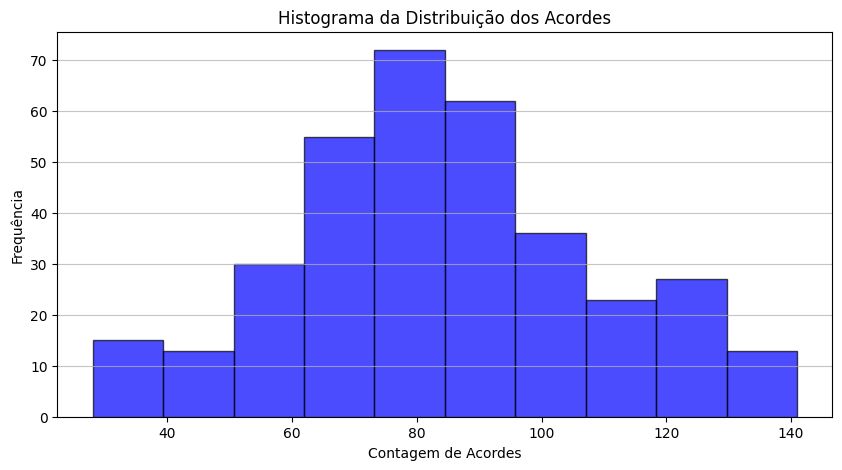

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(analise, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
output_dir = "chords/variation_chord_audio_augmented/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def augment_audio(y, sr, output_dir,file_path):
    transformations = ['pitch_shift', 'time_stretch', 'noise', 'reverb', 'volume_adjust']
    transformation = random.choice(transformations)

    transformation_label = "teste"
    if transformation == 'pitch_shift':
        pitch_steps = random.randint(-2, 2)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_steps)
        transformation_label = f"pitch_{pitch_steps}"
    elif transformation == 'time_stretch':
        rate = random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=rate)
        transformation_label = f"stretch_{round(rate, 2)}"
    elif transformation == 'noise':
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y = y + noise_amp * np.random.normal(size=y.shape[0])
        transformation_label = "noise"
    elif transformation == 'reverb':
        reverb_length = int(sr * 0.3)  # reverberação de 300 ms
        impulse_response = np.zeros(reverb_length)
        impulse_response[0] = 1
        impulse_response[::int(sr*0.1)] = 0.5  # exemplo de resposta impulsiva simples
        y = np.convolve(y, impulse_response)[:len(y)]
        transformation_label = "reverb"
    elif transformation == 'volume_adjust':
        volume_change = np.random.uniform(0.7, 1.3)
        y = y * volume_change
        transformation_label = f"vol_{round(volume_change, 2)}"

    file_name = os.path.basename(file_path)
    file_name_without_ext = os.path.splitext(file_name)[0]
    output_filename = os.path.join(output_dir, f"{file_name_without_ext}_a_{transformation_label}.mp3")
    sf.write(output_filename, y, sr)

    return output_filename

In [ ]:
target_instance = analise.quantile(0.25)
class_counts = filtered_rows['chord'].value_counts()
median_instances = class_counts.median()
data_aug_rate = class_counts.apply(lambda x: max(median_instances - x, 0) if x < target_instance else 0)

In [ ]:
augmented_data = []

for chord in tqdm(class_counts.index, desc='Overall Progress', leave=True):
    rate = data_aug_rate[chord]
    if rate > 0:
        class_subset = filtered_rows[filtered_rows['chord'] == chord]
        class_subset = class_subset.sample(frac=1).reset_index(drop=True)
        samples_to_augment = class_subset.head(int(rate))
        for _, row in samples_to_augment.iterrows():
            try:
                y, sr = librosa.load(row['file_path'], sr=None)
                output_file_path = augment_audio(y, sr, output_dir, row['file_path'])
                new_row = row.copy()
                new_row['file_path'] = output_file_path
                augmented_data.append(new_row)
            except Exception as e:
                print(f"Erro ao processar {row['file_path']}: {e}")

augmented_df = pd.DataFrame(augmented_data)

Overall Progress: 100%|██████████| 346/346 [07:14<00:00,  1.26s/it]


In [ ]:
augmented_df.to_csv('augmented_data.csv', index=False)
combined_df = pd.concat([filtered_rows, augmented_df], ignore_index=True)

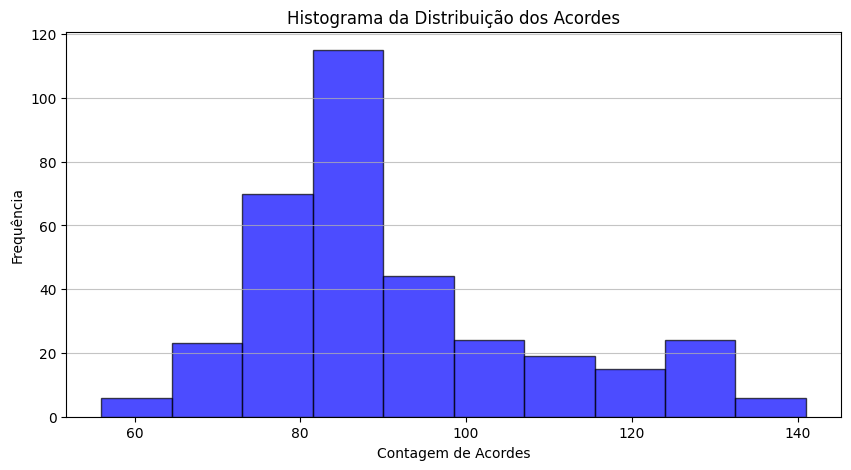

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(combined_df['chord'].value_counts(), bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
combined_df['chord'].value_counts()

E7sus4     141
F#7sus4    138
Bm11       137
Cm11       134
Cmaj13     133
          ... 
D#aug       62
C5          62
D#5         56
C#5         56
D5          56
Name: chord, Length: 346, dtype: int64

In [ ]:
target_instance = analise.quantile(0.75)
target_std = round(analise.std(),0)
# data_aug_rate_down = class_counts.apply(lambda x: target_std + round(target_std * (1-target_instance/x),0) if x > target_instance else 0)
data_aug_rate_down = class_counts.apply(lambda x: target_std + round(target_std * (1-target_instance/x) * 1.2,0) if x > target_instance else 0)

In [ ]:
for label, group in combined_df.groupby('chord'):
    rate = data_aug_rate_down[label]
    if rate > 0:
        # Seleciona aleatoriamente 'rate' amostras para remover
        samples_to_remove = group.sample(n=int(rate))
        # Remove as amostras selecionadas do dataframe original
        combined_df = combined_df.drop(samples_to_remove.index)

combined_df.reset_index(drop=True, inplace=True)

In [ ]:
combined_df['chord'].value_counts()

E7sus4     108
F#7sus4    106
Bm11       105
Cm11       102
Cmaj13     102
          ... 
E5          62
C5          62
C#5         56
D#5         56
D5          56
Name: chord, Length: 346, dtype: int64

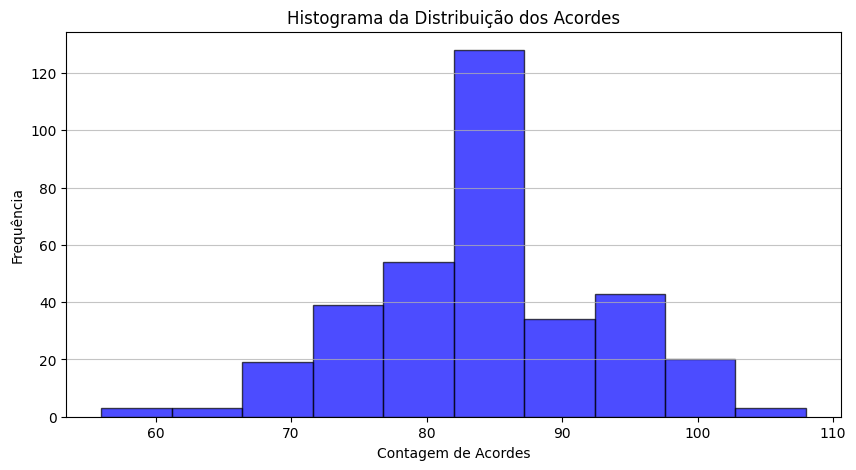

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(combined_df['chord'].value_counts(), bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Duplicação e Inversão de Áudio

In [ ]:
output_dir = "chords/variation_chord_audio_extended/"
os.makedirs(output_dir, exist_ok=True)

#### Funções

In [ ]:
def inverted_audio(file_path, output_dir, file_write = False):
    # Carregar o áudio
    y, sr = librosa.load(file_path, sr=None)
    # Aplicar trim para remover silêncio
    y, _ = librosa.effects.trim(y, top_db=30)
    # Detectar onsets
    onsets = librosa.onset.onset_detect(y=y, sr=sr, units='samples')

    # Definição da função auxiliar para encontrar o ataque antes dos onsets
    def find_attack_before_onsets(y, onsets, lookback_frames=2000):
        attack_points = []
        for onset in onsets:
            start = max(onset - lookback_frames, 0)
            attack_point = start + np.argmin(y[start:onset])
            attack_points.append(attack_point)
        return np.array(attack_points)

    # Encontrar os pontos de ataque antes dos onsets
    attack_points = find_attack_before_onsets(y, onsets)

    # Incluir o início e o fim do áudio
    onset_boundaries = np.concatenate(([0], attack_points, [len(y)]))

    # Ajustar o último boundary baseado na média dos comprimentos anteriores
    wave_lengths = np.diff(onset_boundaries)
    average_length = np.mean(wave_lengths[:-1])
    onset_boundaries[-1] = onset_boundaries[-2] + int(average_length)
    onset_boundaries[-1] = min(onset_boundaries[-1], len(y))  # Garantir que não ultrapasse o comprimento do áudio

    # Dividir o áudio em segmentos
    audio_beats = [y[onset_boundaries[i]:onset_boundaries[i + 1]] for i in range(len(onset_boundaries) - 1)]

    # Reverter a ordem dos segmentos de áudio, excluindo o último se ele for muito curto
    reversed_audio = np.concatenate(audio_beats[::-1])
    reversed_audio = reversed_audio[:-1]

    # Escrever o áudio processado em um arquivo
    file_name = os.path.basename(file_path)
    file_name_without_ext = os.path.splitext(file_name)[0]
    extended_file_path = f"{output_dir}/{os.path.splitext(file_name_without_ext)[0]}_reverted.mp3"
    if file_write:
        sf.write(extended_file_path, reversed_audio, sr)

    return extended_file_path, reversed_audio

In [ ]:
def adjust_audio_length(file_path, output_dir, file_write = False):
    # Carregar o áudio
    y, sr = librosa.load(file_path, sr=None)
    # Aplicar trim para remover silêncio
    y, _ = librosa.effects.trim(y, top_db=30)
    # Detectar onsets
    onsets = librosa.onset.onset_detect(y=y, sr=sr, units='samples')

    # Encontrar os pontos de ataque antes dos onsets
    def find_attack_before_onsets(y, onsets, lookback_frames=2000):
        attack_points = []
        for onset in onsets:
            start = max(onset - lookback_frames, 0)
            attack_point = start + np.argmin(y[start:onset])
            attack_points.append(attack_point)
        return np.array(attack_points)

    attack_points = find_attack_before_onsets(y, onsets)

    # Incluir o início e o fim do áudio
    onset_boundaries = np.concatenate(([0], attack_points, [len(y)]))

    # Ajustar o último boundary baseado na média dos comprimentos anteriores
    wave_lengths = np.diff(onset_boundaries)
    average_length = np.mean(wave_lengths[:-1])

    # Se o último segmento for maior que a média, ajustá-lo
    if wave_lengths[-1] > average_length:
        onset_boundaries[-1] = onset_boundaries[-2] + int(average_length)

    # Dividir o áudio em segmentos
    audio_beats = [y[onset_boundaries[i]:onset_boundaries[i + 1]] for i in range(len(onset_boundaries) - 1)]

    # Concatenar os segmentos para formar o áudio final
    trimmed_audio = np.concatenate(audio_beats)

    # Escrever o áudio ajustado em um arquivo
    file_name = os.path.basename(file_path)
    file_name_without_ext = os.path.splitext(file_name)[0]
    adjusted_file_path = os.path.join(output_dir, f"{file_name_without_ext}_trimmed.mp3")
    if file_write:
        sf.write(adjusted_file_path, trimmed_audio, sr)

    return adjusted_file_path, trimmed_audio

In [ ]:
def extend_audio(file_path, output_dir, extension_factor, inverted = False):
    y, sr = librosa.load(file_path, sr=None)

    contains_strum = 'strum' in os.path.basename(file_path).lower()

    if inverted:
        _, y = inverted_audio(file_path,output_dir)
        x = 'inv'
    elif contains_strum:
        y, _ = librosa.effects.trim(y, top_db=30)
        x = 'only_trim'
    else:
        _, y = adjust_audio_length(file_path,output_dir)
        x = 'norm'

    extended_audio = np.tile(y, extension_factor)
    file_name = os.path.basename(file_path)
    file_name_without_ext = os.path.splitext(file_name)[0]
    extended_file_path = f"{output_dir}/{os.path.splitext(file_name_without_ext)[0]}_extended_{extension_factor}x_{x}.mp3"
    extended_file_path = f"{output_dir}{os.path.splitext(file_name_without_ext)[0]}_extended_{extension_factor}x.mp3"
    sf.write(extended_file_path, extended_audio, sr)
    return extended_file_path

#### Aplicação das Funções em Loop

In [ ]:
extended_list = []

for file_path in tqdm(labels['file_path'], desc='Overall Progress', leave=True):
    for factor in [2, 3]:
        extended_file_path = extend_audio(file_path, output_dir, factor, False)
        new_row = labels[labels['file_path'] == file_path].iloc[0].copy()
        new_row['file_path'] = extended_file_path
        extended_list.append(new_row)

Overall Progress: 100%|██████████| 37131/37131 [2:25:42<00:00,  4.25it/s]


In [ ]:
for file_path in tqdm(labels['file_path'], desc='Overall Progress', leave=True):
    for factor in [2, 3]:
        extended_file_path = extend_audio(file_path, output_dir, factor, True)
        new_row = labels[labels['file_path'] == file_path].iloc[0].copy()
        new_row['file_path'] = extended_file_path
        extended_list.append(new_row)

Overall Progress: 100%|██████████| 37131/37131 [2:23:20<00:00,  4.32it/s]


In [ ]:
df_extended = pd.DataFrame(extended_list)
df_extended.to_csv('extended_data.csv', index=False)
combined_df = pd.concat([combined_df, df_extended], ignore_index=True)

In [ ]:
analise = combined_df['chord'].value_counts()

In [ ]:
filtered_rows.to_csv('filtered_rows.csv', index=False)

In [ ]:
folders_to_zip = [
    'chords/variation_chord_audio_augmented',
    'chords/variation_chord_audio_extended',
    'filtered_rows.csv',
    'augmented_data.csv',               # Dados equilibrados (aumento de dados abaixo do percentil 25)
    'extended_data.csv',                # Dados extendidos por meio de aumento do áudio e inversão (feito 2 e 3 vezes)
]

zip_file_name = 'audio_extend_augmented_bckup.zip'

In [ ]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

In [ ]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')

Arquivo audio_extend_augmented_bckup.zip enviado com sucesso para o bucket.


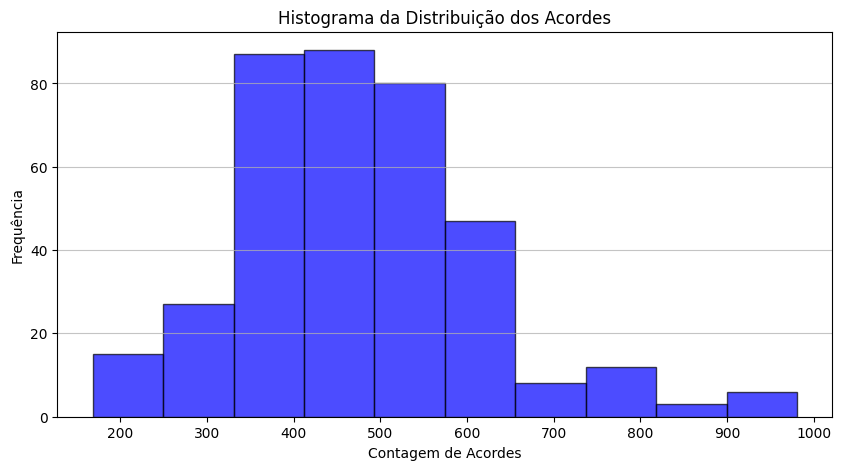

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(analise, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
print(
    f'Media: {round(analise.mean(),2)}',
    f'Percentil 25: {round(analise.quantile(0.25),2)}',
    f'Mediana: {round(analise.median(),2)}',
    f'Percentil 75: {round(analise.quantile(0.75),2)}',
    f'Desvio Padrão: {round(analise.std(),2)}',
    f'Moda: {analise.mode()}',
    f'Max: {analise.max()}',
    f'Min: {analise.min()}',
    sep='\n'
)

Media: 475.79
Percentil 25: 380.0
Mediana: 467.0
Percentil 75: 552.0
Desvio Padrão: 140.38
Moda: 0    485
1    499
2    547
Name: chord, dtype: int64
Max: 981
Min: 168


### Adições de Ruídos

#### Short audio

In [ ]:
noise_path = "chords/noise_audios/short_sounds/"
output_dir = "chords/variation_chord_audio_short_noise/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
short_audio_list = []

In [ ]:
def add_noises_short_sounds(file_path, output_dir, noise_path,i, sr=None):
    noise_list = []
    error = 0
    while True:
        try:
            subfolder_choiced = random.choice(os.listdir(noise_path))
            file_subpath = os.path.join(noise_path, subfolder_choiced)
            choosen_noise = random.choice(os.listdir(file_subpath))
            noise_file_path = os.path.join(file_subpath, choosen_noise)
            choosen_noise_name = os.path.splitext(choosen_noise)[0]
            choosen_noise_name = choosen_noise_name.replace(' ','_').lower()
            noise, _ = librosa.load(noise_file_path, sr=sr)
            y, sr = librosa.load(file_path, sr=sr)
            y, _ = librosa.effects.trim(y, top_db=30)
            repated_noise = np.tile(noise, int(np.ceil(len(y) / len(noise))))[:len(y)]

            vol_rate = [.05,.1,.2,.3,.5]

            file_name = os.path.basename(file_path)
            file_name_without_ext = os.path.splitext(file_name)[0]
            for rate in vol_rate:
                y_noise = y + repated_noise * rate
                new_file_path = f'{output_dir}{file_name_without_ext}_v_{rate}_c_{choosen_noise_name}_r_{i}.mp3'
                sf.write(new_file_path, y_noise, sr)

                dict_noise = {
                    'file_path': new_file_path,
                    'y_noise': y_noise
                }

                noise_list.append(dict_noise)
            break
        except Exception as e:
            print(f'Erro ao processar {noise_path}: {e}')
            error += 1
            if error > 20:
                break
    return noise_list

In [ ]:
for file_path in tqdm(combined_df['file_path'], desc='Overall Progress', leave=True):
    for i in range(5):
        new_row = combined_df[combined_df['file_path'] == file_path].iloc[0].copy()
        short_audio = add_noises_short_sounds(file_path, output_dir, noise_path, i, None)
        for noise in short_audio:
            new_row['file_path'] = noise['file_path']
            short_audio_list.append(new_row)

In [ ]:
df_short_audio = pd.DataFrame(short_audio_list)
df_short_audio.to_csv('short_audio_data.csv', index=False)

In [ ]:
folders_to_zip = [
    'chords/variation_chord_audio_short_noise/',
    'short_audio_data.csv',               # Dados equilibrados (aumento de dados abaixo do percentil 25)
]

zip_file_name = 'audio_short_noise_bck.zip'

In [ ]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

In [ ]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')

#### World Audio

In [ ]:
noise_path = "chords/noise_audios/world_sounds/"
output_dir = "chords/variation_chord_audio_world_noise/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
world_audio_list = []

In [ ]:
def add_noises_world_sounds(file_path, output_dir, noise_path,i, sr=None, white_nose = False, vol_rate = list):
    noise_list = []
    error = 0
    while True:
        try:
            if white_nose:
                choosen_noise = random.choice(os.listdir(noise_path))
                noise_file_path = os.path.join(noise_path, choosen_noise)
            else:
                subfolder_choiced = random.choice(os.listdir(noise_path))
                file_subpath = os.path.join(noise_path, subfolder_choiced)
                choosen_noise = random.choice(os.listdir(file_subpath))
                noise_file_path = os.path.join(file_subpath, choosen_noise)

            choosen_noise_name = os.path.splitext(choosen_noise)[0]
            choosen_noise_name = choosen_noise_name.replace('- ','').replace(',','').replace(' ','_').lower()
            choosen_noise_name = choosen_noise_name.split('_')[:3]
            choosen_noise_name = '_'.join(choosen_noise_name)

            noise, _ = librosa.load(noise_file_path, sr=sr)
            y, sr = librosa.load(file_path, sr=sr)
            y, _ = librosa.effects.trim(y, top_db=30)

            if len(noise) < len(y):
                start_point = random.randint(0, len(y) - len(noise))
                noise = np.tile(noise, int(np.ceil(len(y) / len(noise))))[start_point:start_point + len(y)]
            else:
                start_point = random.randint(0, len(noise) - len(y))
                noise = noise[start_point:start_point + len(y)]

            file_name = os.path.basename(file_path)
            file_name_without_ext = os.path.splitext(file_name)[0]

            for rate in vol_rate:
                y_noise = y + noise * rate
                new_file_path = f'{output_dir}{file_name_without_ext}_v_{rate}_c_{choosen_noise_name}_r_{i}.mp3'
                sf.write(new_file_path, y_noise, sr)

                dict_noise = {
                    'file_path': new_file_path,
                    'y_noise': y_noise
                }

                noise_list.append(dict_noise)
            break
        except Exception as e:
            print(f'Erro ao processar {file_path}: {e}')
            error += 1
            if error > 20:
                break
    return noise_list

In [ ]:
vol_rate = [.05,.1,.2,.5,1]

for file_path in tqdm(labels['file_path'], desc='Overall Progress', leave=True):
    for i in range(5):
        new_row = labels[labels['file_path'] == file_path].iloc[0].copy()
        short_audio = add_noises_world_sounds(file_path, output_dir, noise_path, i, None, False, vol_rate)
        for noise in short_audio:
            new_row['file_path'] = noise['file_path']
            world_audio_list.append(new_row)

In [ ]:
df_world_audio = pd.DataFrame(world_audio_list)
df_world_audio.to_csv('world_audio_data.csv', index=False)

### White Noise

In [ ]:
noise_path = "chords/noise_audios/white_noise_sfx/"
output_dir = "chords/variation_chord_audio_white_noise/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
white_noise_list = []

In [ ]:
vol_rate = [.05,.1,.2,.4]

for file_path in tqdm(labels['file_path'], desc='Overall Progress', leave=True):
    for i in range(3):
        new_row = labels[labels['file_path'] == file_path].iloc[0].copy()
        short_audio = add_noises_world_sounds(file_path, output_dir, noise_path, i, None, True, vol_rate)
        for noise in short_audio:
            new_row['file_path'] = noise['file_path']
            white_noise_list.append(new_row)

In [ ]:
df_white_noise = pd.DataFrame(white_noise_list)
df_white_noise.to_csv('white_noise_data.csv', index=False)

### Conversão .rar e envio para o Blob

#### Audio Data to blob

In [ ]:
folders_to_zip = [
    'chords/variation_chord_audio',
    'chords/variation_chord_audio_augmented',
    'chords/variation_chord_audio_extended',
    'chords/variation_chord_audio_noise_short',
    'chords/variation_chord_audio_noise_world',
    'chords/variation_chord_audio_white_noise'
]

zip_file_name = 'audio_data.zip'

In [ ]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

In [ ]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')

#### DataFrames to blob

In [ ]:
folders_to_zip = [
    'augmented_data.csv',               # Dados equilibrados (aumento de dados abaixo do percentil 25)
    'extended_data.csv',                # Dados extendidos por meio de aumento do áudio e inversão (feito 2 e 3 vezes)
    'short_audio_data.csv',             # Dados com ruídos curtos
    'world_audio_data.csv',             # Dados com ruídos do mundo
    'white_noise_data.csv',             # Dados com ruídos brandos
    'total_data_labels.csv'             # Junção total dos dados tratados
]

zip_file_name = 'table_data.zip'

In [ ]:
!zip -r {zip_file_name} {" ".join(folders_to_zip)}

In [ ]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(zip_file_name)
blob.upload_from_filename(zip_file_name)

print(f'Arquivo {zip_file_name} enviado com sucesso para o bucket.')